In [22]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [23]:
%%capture output
!unzip Model.zip

In [24]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series
from neural_simulations import run_neural_simulations, run_flexor_extensor_neuron_simulation
from activation import decode_spikes_to_activation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
t_reaction = 40*ms
n_loop=2
dt = 0.1*ms

neuron_population = {"Ia": 60, "II": 60,"inh":196, "exc": 196, "motor": 169}
ees_params={
    'ees_freq':50*hertz,
    'aff_recruited':0.9,
    'eff_recruited':0.9}
biophysical_params={
    'p':0.4,
    'w':10*uS,
    'T_refr':2*ms
}

muscle_name ="tib_ant_r,med_gas_r"

muscle_names = muscle_name.split(",")
n_muscles = len(muscle_names)

if n_muscles !=2:
  print("This pipeline require 2 muscles!")
  raise ValueError

stretch, velocity = np.zeros((n_muscles,int(t_reaction/dt))), np.zeros((n_muscles,int(t_reaction/dt)))
initial_stretch=stretch
initial_values_decoding_spikes=[{i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0':[0.0], 'a0':[0.0]} for i in range(neuron_population["motor"])} for j in range(n_muscles)]


data_muscle = [[] for _ in range(n_muscles)]
resting_length = [None] * n_muscles  # One resting length per muscle

name_output_spikes = 'spikes'

data_spikes = {
    "flexor": {
        "Ia": defaultdict(list),
        "II": defaultdict(list),
        "MN": defaultdict(list)
    },
    "extensor": {
        "Ia": defaultdict(list),
        "II": defaultdict(list),
        "MN": defaultdict(list)
    }
}

results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)
final_states_opensim=os.path.join(results_folder, 'final.json')

for j in range(n_loop):

    print(f"--- Iteration {j+1} ---")
    spikes_all=run_flexor_extensor_neuron_simulation(stretch, velocity, neuron_population,dt,t_reaction, **ees_params, **biophysical_params)
    for muscle_group, muscle_spikes in spikes_all.items():
      for fiber_name, fiber_spikes in muscle_spikes.items():
        for neuron_id, spikes in fiber_spikes.items():
          data_spikes[muscle_group][fiber_name][neuron_id].extend(spikes/second+j*t_reaction/second)

    mean_e,mean_u,mean_c,mean_P,mean_activation=[np.zeros((n_muscles,int(t_reaction/dt))) for i in range(5)]

    for i, (key, value) in enumerate(spikes_all.items()):

        if len(muscle_spikes["MN"])>0:

            e,u,c,P,activations, final_values=decode_spikes_to_activation([value/second for key, value in value["MN"].items()], dt/second, t_reaction/second, initial_values_decoding_spikes[i])
            mean_activation[i] = np.mean(activations, axis=0)
            mean_e[i]= np.mean(e, axis=0)
            mean_u[i] = np.mean(u, axis=0)
            mean_c[i] = np.mean(c, axis=0)
            mean_P[i] = np.mean(P, axis=0)

            initial_values_decoding_spikes[i] = final_values


    # Create temporary files for both input and output
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp, \
        tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_tmp:

        input_path = input_tmp.name
        output_path = output_tmp.name
        np.save(input_path, mean_activation)


        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second),
            '--muscles', muscle_name,
            '--activation', input_path,
            '--output_stretch', output_path,
            '--output_final_state', final_states_opensim]
        if j>0:
          cmd += ['--initial_state', final_states_opensim]

        # Run the process in the other environment
        process = subprocess.run(cmd, capture_output=True, text=True)

        if process.stdout.strip():
            print("STDOUT:\n", process.stdout)

        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            fiber_lengths = np.load(output_path)
            fiber_lengths = fiber_lengths[:,:-1]#The last value of the stretching simulated will be included in the next iteration, the final state is used for the next simulation
            for k in range(n_muscles):

                if j == 0:
                    resting_length[k]=fiber_lengths[k,0]

                stretch[k] = fiber_lengths[k] / resting_length[k] - 1
                velocity[k] = np.gradient(stretch[k], np.arange(0, t_reaction/second, dt/second))

                # Create batch data dictionary
                batch_data = {
                    f'mean_e': mean_e[k],
                    'mean_u': mean_u[k],
                    'mean_c': mean_c[k],
                    'mean_P': mean_P[k],
                    'mean_activation': mean_activation[k],
                    'fiber_length': fiber_lengths[k],
                    'stretch': stretch[k],
                    'velocity': velocity[k]
                }

                df = pd.DataFrame(batch_data)
                data_muscle[k].append(df)
        else:
          raise RuntimeError(f'Problem in iteration {j}. STDERR: {process.stderr}')

        # Clean up temporary files
        os.unlink(input_path)
        os.unlink(output_path)

#Sto file to store the activations for visualization on opensim
muscles_data=[]
df_sto = pd.DataFrame()
path_muscles=[os.path.join(results_folder, f'{muscle_names[i]}_aff_{ees_params["aff_recruited"]}_eff_{ees_params["eff_recruited"]}_freq_{ees_params["ees_freq"]}.csv') for i in range(n_muscles)]
for i, muscle_name in enumerate(muscle_names):
    # Concatenate all batches for the current muscle into one DataFrame
    df_muscle_combined = pd.concat(data_muscle[i], ignore_index=True)

    # Add Time as the first column
    df_muscle_combined['Time'] = np.arange(0, len(df_muscle_combined)) * (dt/second)
    # Reorder columns to place 'Time' first
    df_muscle_combined = df_muscle_combined[['Time'] + [col for col in df_muscle_combined.columns if col != 'Time']]
    muscles_data.append(df_muscle_combined)

    # Create a new DataFrame for the current muscle
    df_sto[muscle_name] = df_muscle_combined['mean_activation']

    # Save the muscle-specific CSV
    df_muscle_combined.to_csv(path_muscles[i], index=False)
    print(f"{path_muscles[i]} saved")

df_sto['time']=np.arange(0, len(df_sto))*dt/second
# Prepare .sto header
sto_header = [
    "Coordinates",
    "version=1",
    f"nRows={len(df_sto)}",
    f"nColumns={len(df_sto.columns)}",
    "inDegrees=no",
    "",
    "endheader"
]

# Write the .sto file
sto_path = os.path.join(results_folder, f'Activations_{muscle_names[0]}_{muscle_names[1]}_aff_{ees_params["aff_recruited"]}_eff_{ees_params["eff_recruited"]}_freq_{ees_params["ees_freq"]}.sto')
with open(sto_path, "w") as f:
    for line in sto_header:
        f.write(line + "\n")
    df_sto.to_csv(f, sep="\t", index=False, float_format="%.6f")

print(f'{sto_path} is saved')

# Save the spikes data
path_spikes = os.path.join(results_folder, f'{name_output_spikes}_aff_{ees_params["aff_recruited"]}_eff_{ees_params["eff_recruited"]}_freq_{ees_params["ees_freq"]}.json')
with open(path_spikes, "w") as f:
    json.dump(data_spikes, f, indent=4)
print(f'{path_spikes} saved')

# Clean up final state file if it exists
if os.path.isfile(final_states_opensim):
    os.remove(final_states_opensim)
    print(f"Deleted: {final_states_opensim}")


--- Iteration 1 ---
STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim


--- Iteration 2 ---
STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
[warning] Coordinate.setValue:  coordinate pelvis_tilt is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_list is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_rotation is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_tx is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate pelvis_tz is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate lumbar_extension is locked. Unable to change its value.
[warning] Coordinate.setValue:  coordinate lumbar_bending is locked. Unab

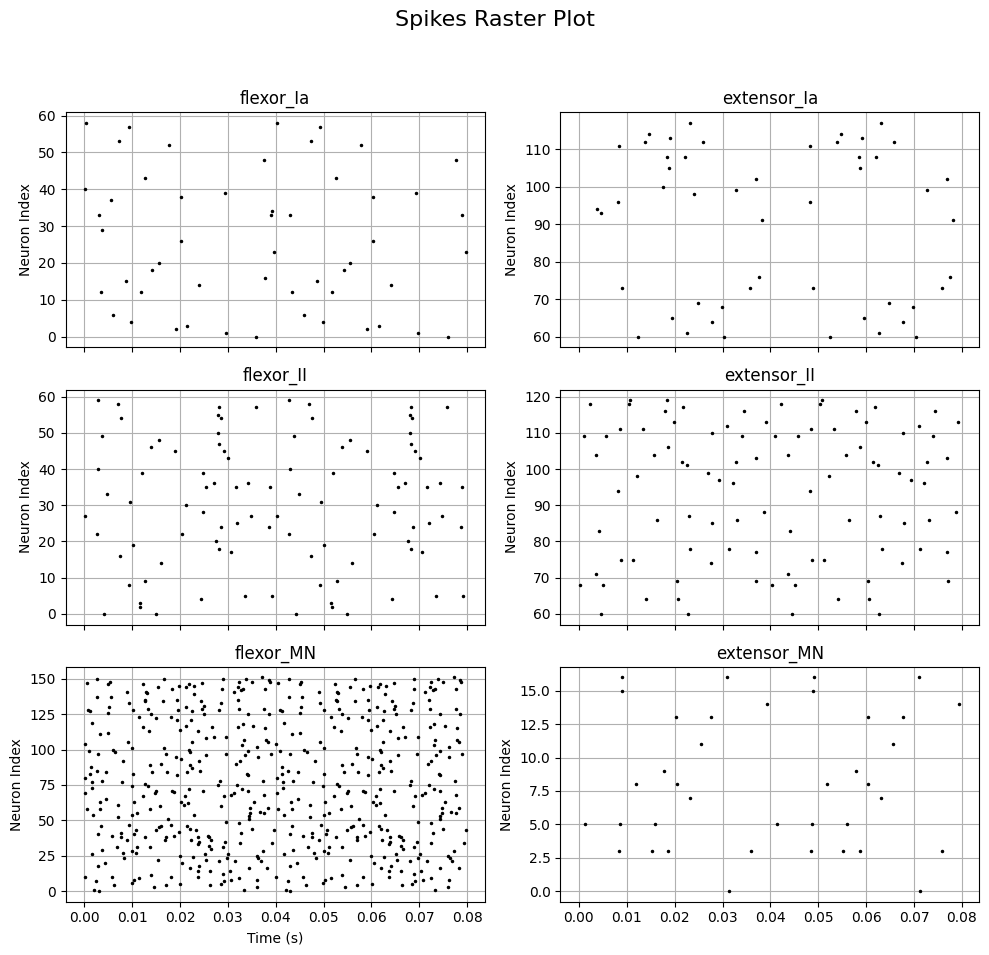

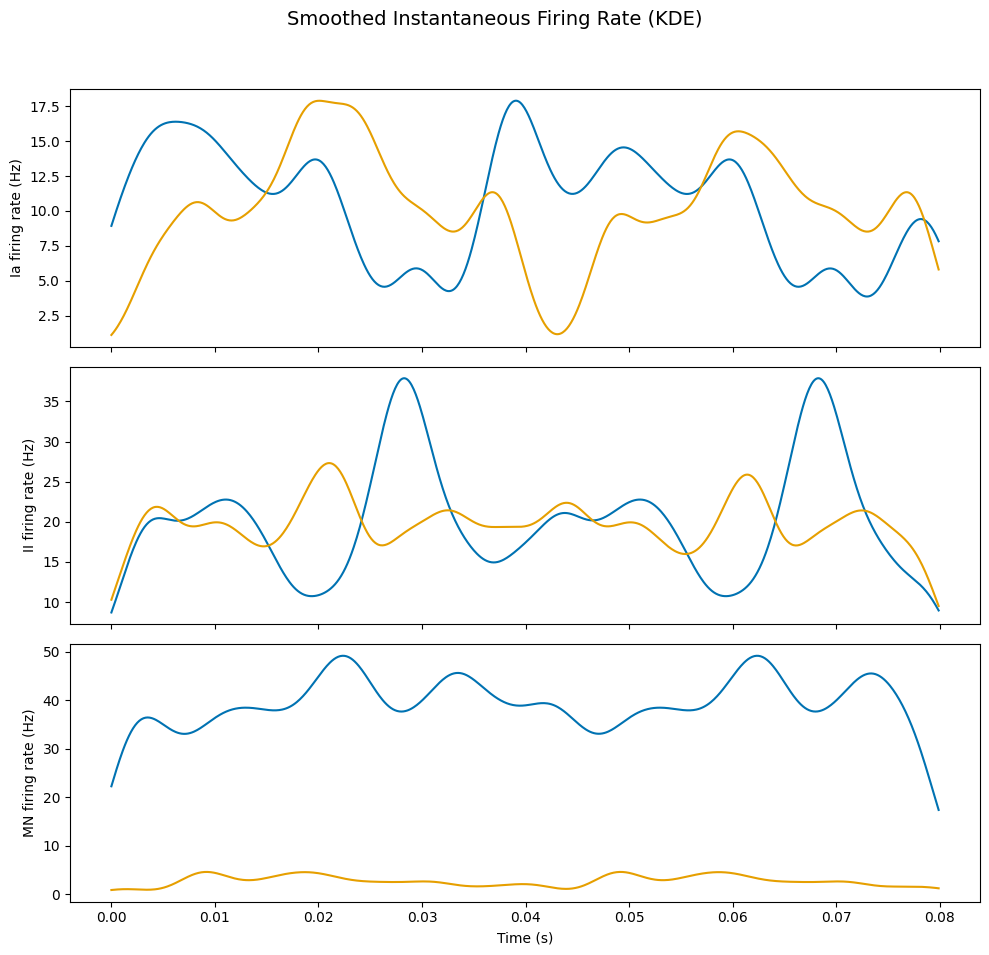

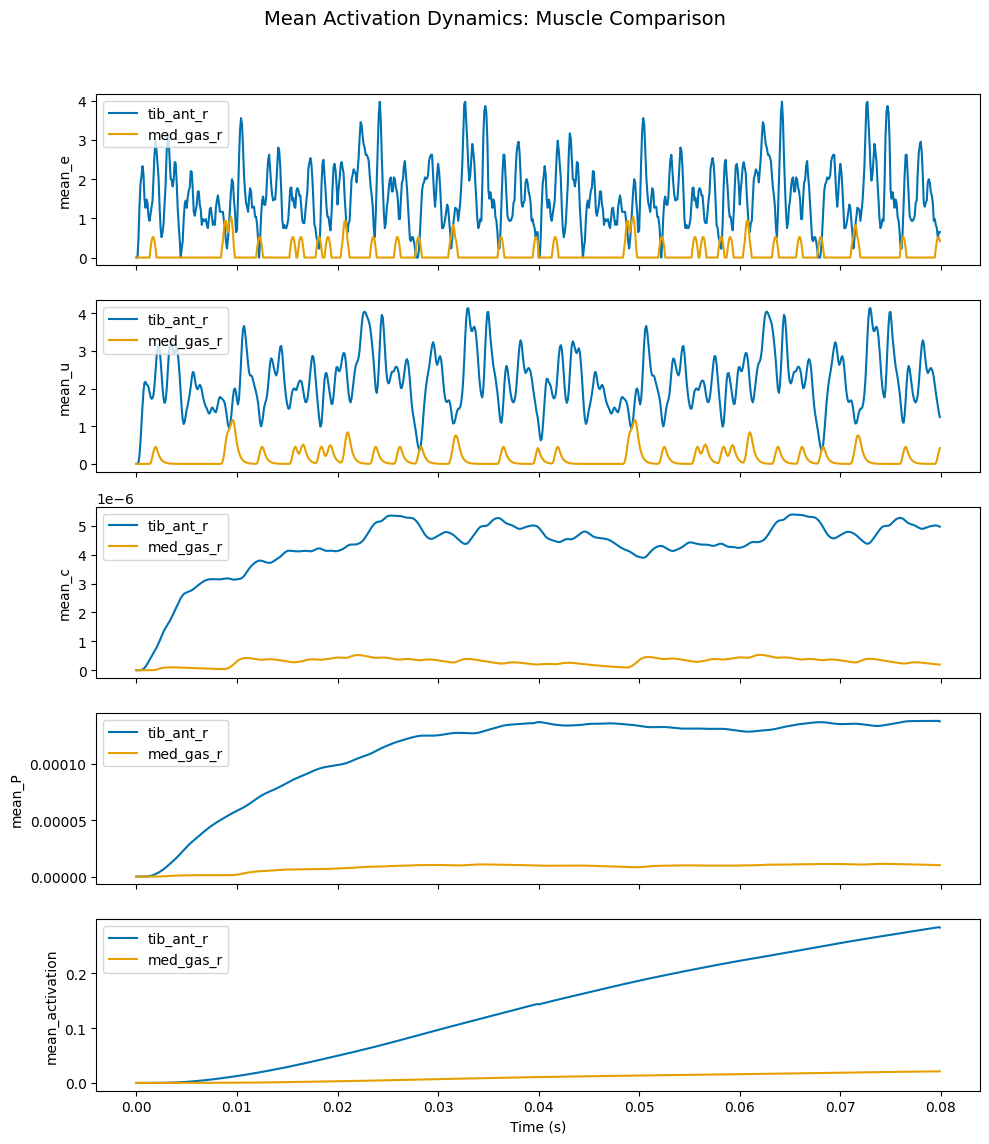

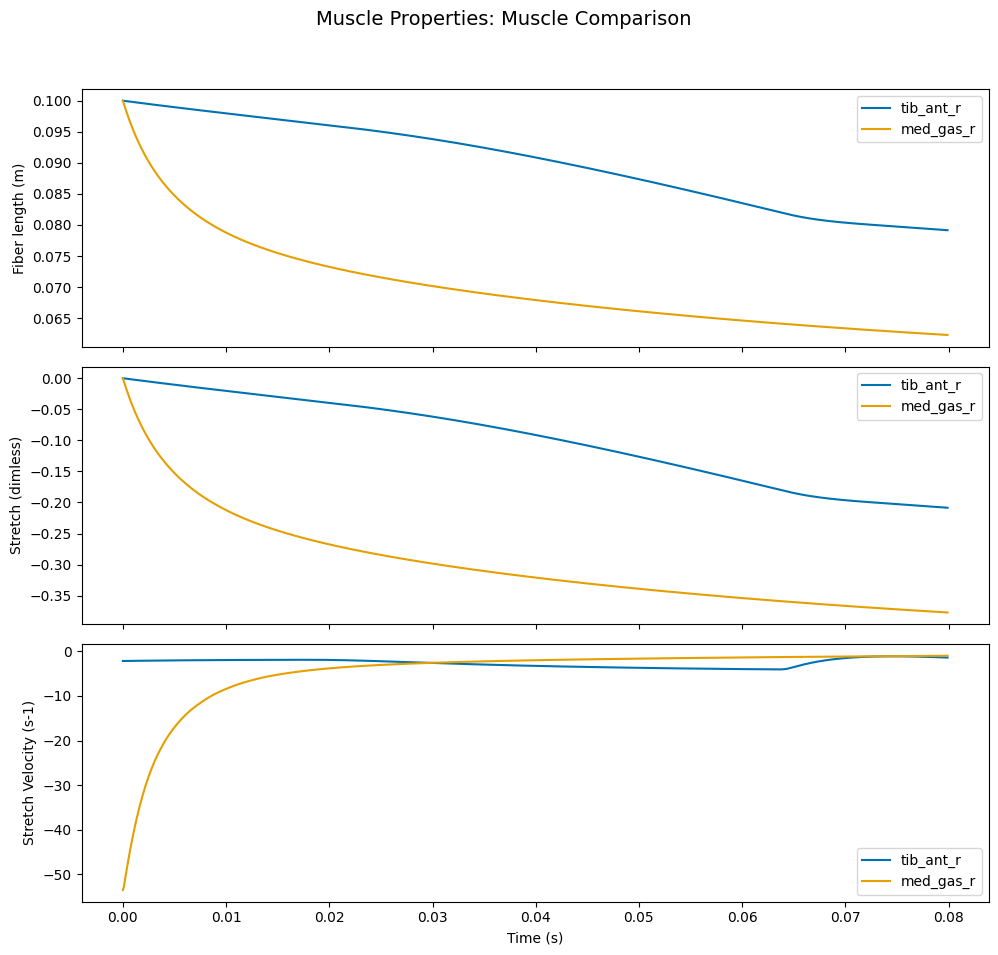

In [33]:

plot_times_series(path_spikes, muscles_data, muscle_names, results_folder,**ees_params)


In [34]:

sto_name=f'All_{ees_params["aff_recruited"]}_eff_{ees_params["eff_recruited"]}_freq_{ees_params["ees_freq"]}.sto'
sto_file= os.path.join(results_folder, sto_name)
#Compute the sto file with the entire simulation for all the variables
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp:

    input_path = input_tmp.name
    np.save(input_path, np.array(df_sto.drop(columns=["time"]).to_numpy()))
    cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second*n_loop),
            '--muscle', muscle_name,
            '--activation', input_path,
            '--output_all', sto_file
          ]

    # Run the process in the opensim environment
    process = subprocess.run(cmd, capture_output=True, text=True)

    if process.stdout.strip():
          print("STDOUT:\n", process.stdout)
    if process.stderr.strip():
          print(f"STDERR: {process.stderr}")

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
results/All_0.9_eff_0.9_freq_50. Hz.sto file is saved




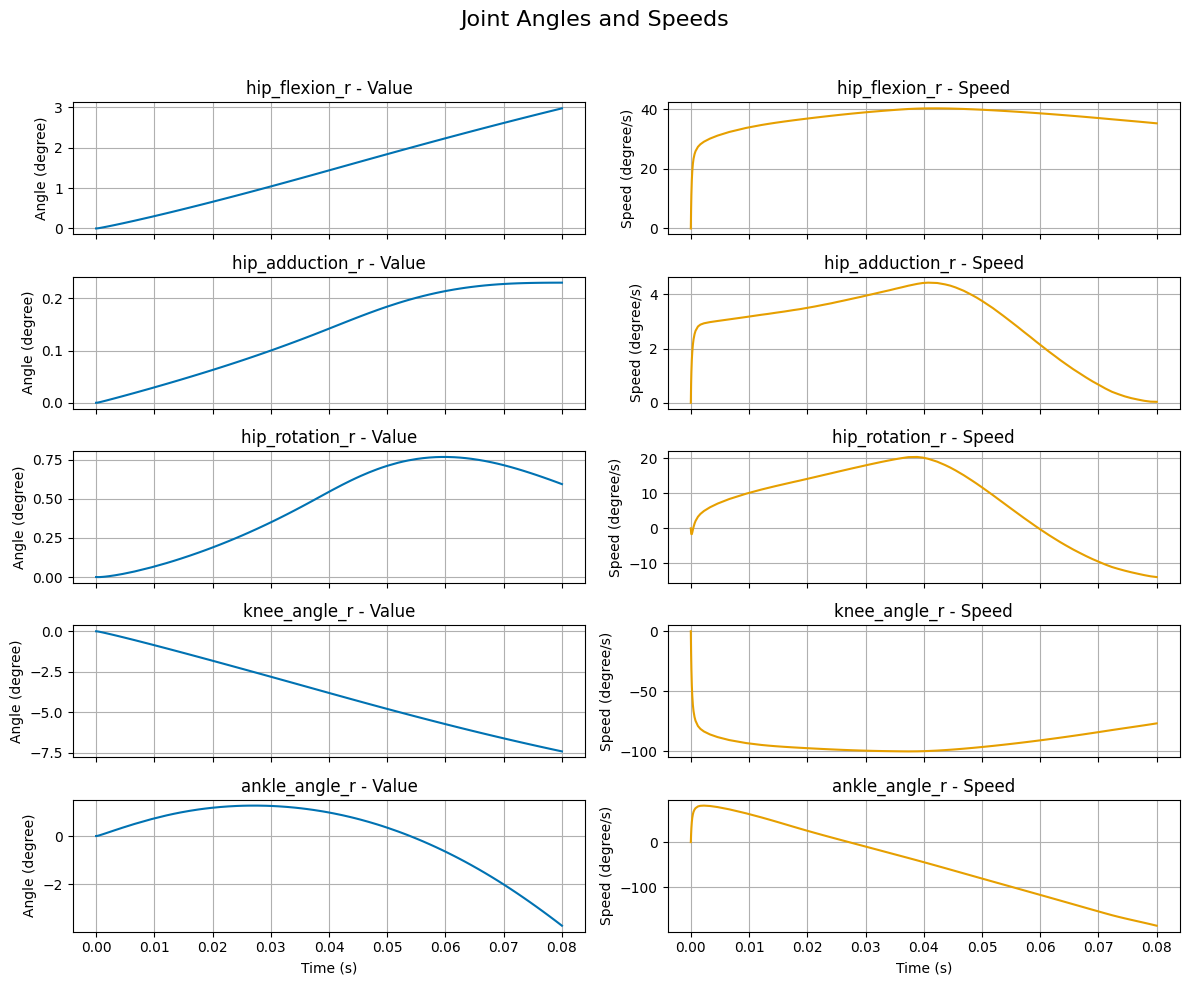

In [38]:
from plot_time_series import plot_joint_angle_from_sto_file as pja
# Define columns of interest
columns_wanted = [
    "hip_flexion_r",
    "hip_adduction_r",
    "hip_rotation_r",
    "knee_angle_r",
    "ankle_angle_r"
]
pja(sto_file, columns_wanted, results_folder, **ees_params)